In [1]:
import deepquantum as dq
import torch
import torch.nn as nn

class QAOA(nn.Module):
    def __init__(self, nqubit, pairs, coefs, step):
        super().__init__()
        self.nqubit = nqubit
        self.pairs = pairs
        self.coefs = torch.tensor(coefs)
        self.step = step
        self.gamma = nn.Parameter(0.1 * torch.ones(step))
        self.beta = nn.Parameter(torch.ones(step))

        self.cir = dq.QubitCircuit(nqubit)
        self.cir.hlayer()
        self.cir.barrier()
        for _ in range(step):  #step量子网络演化步数，步数越高计算越精确
            for wires in pairs:  # Hp项
                self.cir.cnot(wires[0], wires[1])
                self.cir.rz(wires[1], encode=True)
                self.cir.cnot(wires[0], wires[1])
                self.cir.barrier()
            for i in range(nqubit):  # Hb项
                self.cir.rx(i, encode=True)
            self.cir.barrier()
        for wires in pairs: # 测量每一项Hp
            self.cir.observable(wires)

    @property
    def params(self):
        params = torch.empty(0)
        for i in range(self.step):
            gammas = 2 * self.gamma[i] * self.coefs
            betas = 2 * self.beta[i].repeat(self.nqubit)
            params = torch.cat([params, gammas, betas])
        return params

    def draw(self):  # 画出量子线路图
        self.cir.encode(self.params)
        return self.cir.draw()

    def measure(self): # 测量线路
        return self.cir.measure()

    def forward(self):
        self.cir(self.params)
        return sum(self.coefs * self.cir.expectation()[0])   # 测量的哈密顿量可能需要根据具体的问题进行一定的修改

In [2]:
def trainer(model, epoch, lr):
    # 选择优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
    train_loss_list=[]
    for e in range(epoch):
        y_pred = model()
        loss = y_pred
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        train_loss_list.append(loss.detach().numpy())
        print(f'Iteration: {e} loss {loss.item()}')
    # torch.save(model.state_dict(), save_path+model_type+'.pt')   # 保存训练好的模型参数，用于后续的推理或测试
    metrics = {'epoch': list(range(1, len(train_loss_list) + 1)),
                'train_loss': train_loss_list}
    return model, metrics

In [3]:
# 定义问题，有若干个元素，它们如果放在一起，则两两之间有一定的矛盾值，求将他们分为两组，使总矛盾值最小。
problem = {'Z0 Z4': 0.73, 'Z0 Z5': 0.33, 'Z0 Z6': 0.5, 'Z1 Z4': 0.69, 'Z1 Z5': 0.36,
           'Z2 Z5': 0.88, 'Z2 Z6': 0.58, 'Z3 Z5': 0.67, 'Z3 Z6': 0.43}

pairs = []
coefs = []

for key, value in problem.items():
    temp = []
    for item in key.split():
        if item[0] == 'Z':
            temp.append(int(item[1:]))
    if len(temp) == 2:
        pairs.append(temp)
        coefs.append(value)

print('pairs:', pairs)
print('coefs:', coefs)

nqubit = 7  # 比特的总个数，应与problem中的比特数保持一致
step = 4    # 量子网络演化步数，步数越高计算越精确
lr = 0.01   # 定义学习率
epoch = 100 # 定义迭代次数

qaoa_model = QAOA(nqubit, pairs, coefs, step)

pairs: [[0, 4], [0, 5], [0, 6], [1, 4], [1, 5], [2, 5], [2, 6], [3, 5], [3, 6]]
coefs: [0.73, 0.33, 0.5, 0.69, 0.36, 0.88, 0.58, 0.67, 0.43]


In [4]:
optim_model, metrics = trainer(qaoa_model, epoch, lr)

Iteration: 0 loss -0.31839415431022644
Iteration: 1 loss -0.5119128227233887
Iteration: 2 loss -0.7047547698020935
Iteration: 3 loss -0.8936251997947693
Iteration: 4 loss -1.0780837535858154
Iteration: 5 loss -1.2601304054260254
Iteration: 6 loss -1.4398508071899414
Iteration: 7 loss -1.6163134574890137
Iteration: 8 loss -1.7883461713790894
Iteration: 9 loss -1.9547077417373657
Iteration: 10 loss -2.114182472229004
Iteration: 11 loss -2.2656373977661133
Iteration: 12 loss -2.408099412918091
Iteration: 13 loss -2.5408191680908203
Iteration: 14 loss -2.663404941558838
Iteration: 15 loss -2.77587628364563
Iteration: 16 loss -2.878751039505005
Iteration: 17 loss -2.9730467796325684
Iteration: 18 loss -3.0601630210876465
Iteration: 19 loss -3.1417124271392822
Iteration: 20 loss -3.219285249710083
Iteration: 21 loss -3.294245719909668
Iteration: 22 loss -3.3676114082336426
Iteration: 23 loss -3.439955949783325
Iteration: 24 loss -3.5113840103149414
Iteration: 25 loss -3.5815589427948
Iterati

In [5]:
res = qaoa_model.measure()
print(res)
max_key = max(res, key=res.get)
print('最佳分割方案' + str(max_key))

{'0011100': 63, '0000111': 334, '0100011': 35, '0111101': 7, '1111000': 305, '1100011': 70, '0011101': 11, '0100110': 2, '0100111': 13, '1011100': 35, '0100101': 2, '0000101': 6, '1111010': 8, '0001111': 5, '1010011': 1, '1110010': 8, '1111110': 1, '0111100': 6, '0001000': 1, '1110001': 8, '1000011': 4, '1110000': 7, '1000101': 2, '1111100': 1, '0101111': 2, '1000010': 6, '1111001': 1, '0000011': 3, '0010110': 2, '0110001': 1, '1011000': 13, '1100010': 7, '0000100': 1, '0110010': 1, '0011110': 1, '1010110': 1, '1101011': 4, '0101001': 1, '1011111': 1, '0011111': 2, '1011010': 1, '0001110': 1, '1100001': 3, '0001100': 1, '1110100': 1, '0001101': 3, '0111010': 2, '1101010': 5, '0010101': 3, '0010100': 1, '0110111': 1, '0110110': 1, '0101110': 1, '1101101': 1, '1010000': 1, '1000110': 2, '0010011': 1, '0001011': 1, '1100000': 3, '1010010': 1, '0101010': 1, '1100110': 1, '0000001': 1, '1110011': 1, '1001001': 1, '0011001': 1, '0101000': 1, '0100000': 1}
最佳分割方案0000111


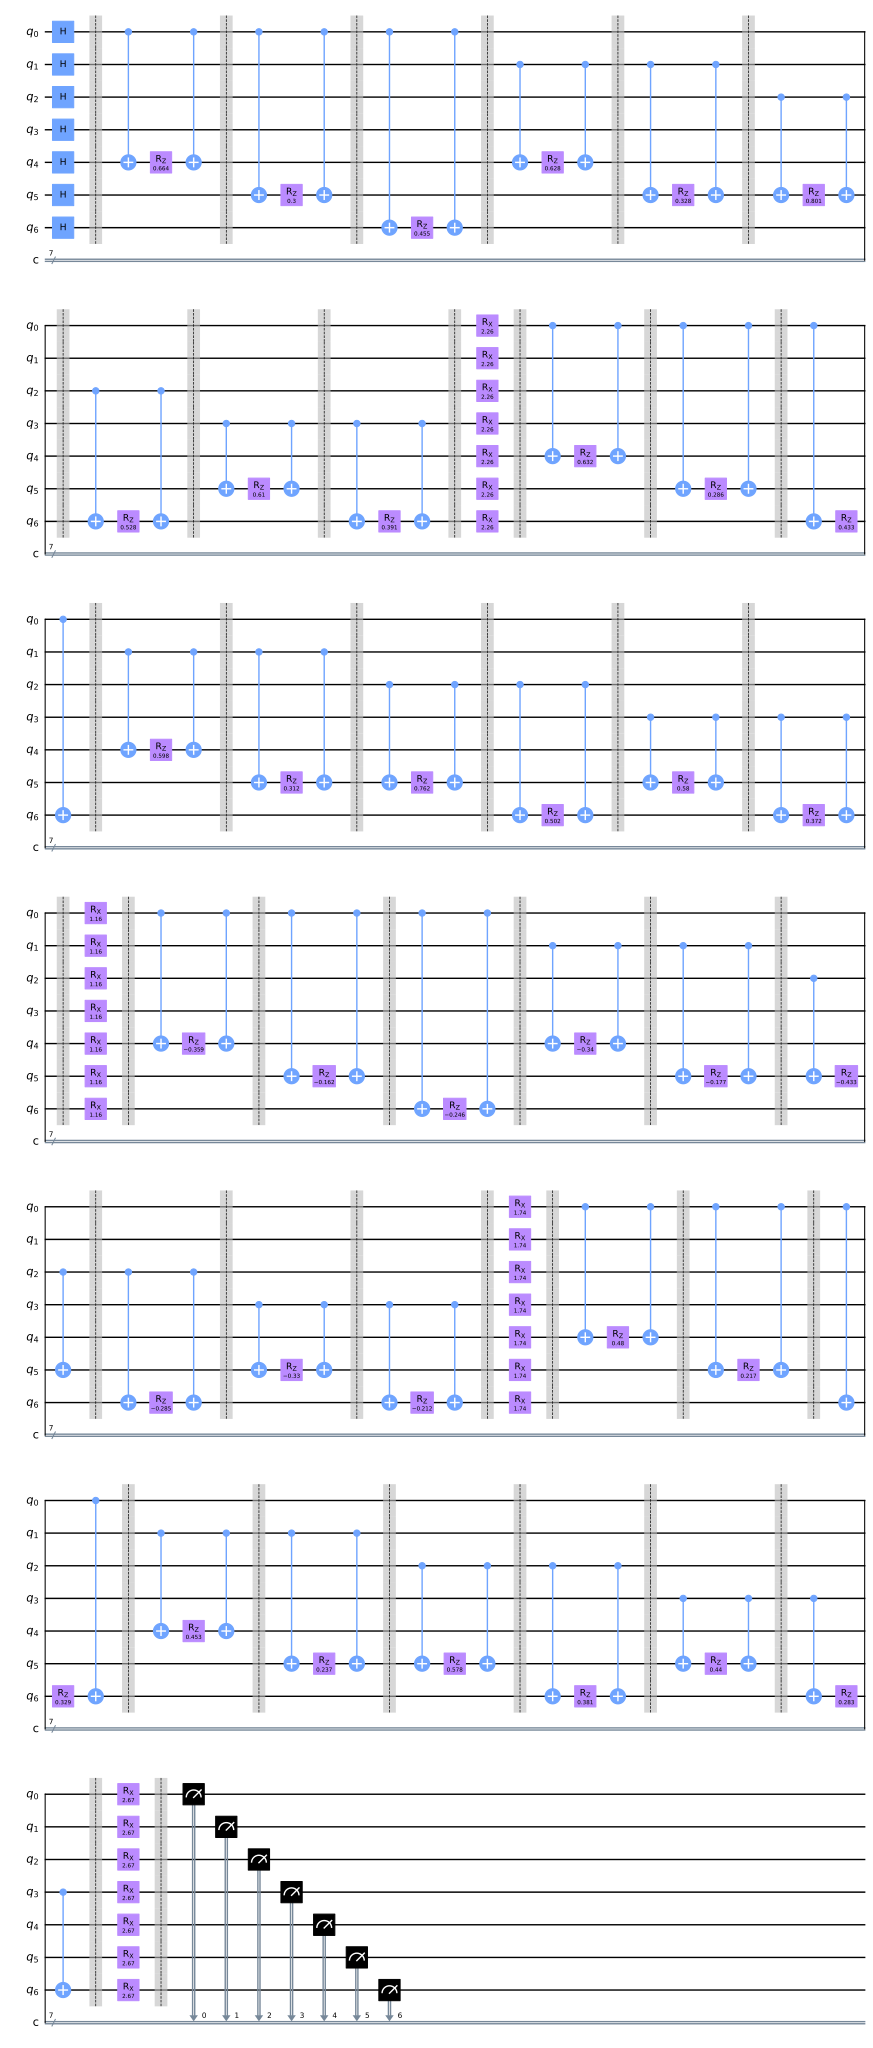

In [6]:
qaoa_model.draw()